<a href="https://colab.research.google.com/github/PCHEN3/UvA/blob/main/Quantitave_Fin_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load packages


In [ ]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
# !pip install plotnine
import plotnine as p9
from matplotlib import pyplot as plt

## Import data

In [ ]:
ff = 'https://raw.githubusercontent.com/PCHEN3/UvA/main/DE_FF_Factors.csv'
ff = pd.read_csv(ff)
d = 'https://raw.githubusercontent.com/PCHEN3/UvA/main/DE_data_long.csv'
d = pd.read_csv(d)
print(ff)
print(d)

      mdate       Rf    MktRf      SMB      HML
0    195807  0.00252  0.03457  0.03221 -0.02137
1    195808  0.00236  0.08535 -0.01284 -0.02355
2    195809  0.00247  0.09147 -0.02363 -0.01922
3    195810  0.00226  0.05334  0.02080 -0.01705
4    195811  0.00236  0.00327  0.01878  0.04144
..      ...      ...      ...      ...      ...
691  201602 -0.00021 -0.02420  0.01251 -0.00116
692  201603 -0.00026  0.04888 -0.01138  0.01171
693  201604 -0.00028  0.00864 -0.00060  0.03955
694  201605 -0.00029  0.02139  0.00307 -0.00562
695  201606 -0.00030 -0.04875  0.00889 -0.02062

[696 rows x 5 columns]
               ISIN   mdate     RET   RET11       ME    beta    ivol
0      DE0001262012  200205  0.3088 -0.5500    10.80  0.4582  0.0870
1      DE0001262012  200206 -0.3333 -0.7135     7.20  0.6200  0.0558
2      DE0001262012  200207 -0.3750 -0.7895     4.50  0.6142  0.0405
3      DE0001262012  200208 -0.0837 -0.8036     4.12  0.4678  0.0439
4      DE0001262012  200209 -0.2183 -0.8657     3.22  0

## Sorting portfolio

In [ ]:
d['RET11_lag2'] = d.groupby('ISIN')['RET11'].shift(2)
d.head()

def sortPort(x, quantiles = 10):
  ranks = pd.qcut(x, quantiles, labels = False, duplicates = "drop") + 1
  ranks = ranks.apply(lambda x: f'p{int(x)}' if not pd.isnull(x) else x)
  return ranks

d['momport']=d.groupby(['mdate'])['RET11_lag2'].apply(lambda x: sortPort(x))
print(d)

               ISIN   mdate     RET   RET11  ...    beta    ivol  RET11_lag2  momport
0      DE0001262012  200205  0.3088 -0.5500  ...  0.4582  0.0870         NaN      NaN
1      DE0001262012  200206 -0.3333 -0.7135  ...  0.6200  0.0558         NaN      NaN
2      DE0001262012  200207 -0.3750 -0.7895  ...  0.6142  0.0405     -0.5500       p3
3      DE0001262012  200208 -0.0837 -0.8036  ...  0.4678  0.0439     -0.7135       p1
4      DE0001262012  200209 -0.2183 -0.8657  ...  0.9192  0.0517     -0.7895       p1
...             ...     ...     ...     ...  ...     ...     ...         ...      ...
67328  DE000TUAG000  200408  0.0647  0.1104  ...  1.3819  0.0206      0.2486       p6
67329  DE000TUAG000  200409 -0.0099  0.0417  ...  1.3119  0.0093      0.0400       p4
67330  DE000TUAG000  200410  0.0901  0.0954  ...  1.3226  0.0086      0.1104       p6
67331  DE000TUAG000  200411  0.0263  0.0565  ...  1.1475  0.0093      0.0417       p6
67332  DE000TUAG000  200412  0.0405 -0.0420  ...  1.14

##Calculate momentum portfolio returns

In [ ]:
d = d.groupby(['momport','mdate']).mean()['RET']
d = d.reset_index()
print(d.head())

d = d.pivot(index = 'mdate', columns = 'momport', values = 'RET')
d["WML"] = d["p10"] - d["p1"]
print(d.head())

  momport   mdate       RET
0      p1  199103  0.052148
1      p1  199104  0.027210
2      p1  199105 -0.019410
3      p1  199106  0.002571
4      p1  199107 -0.064681
momport        p1       p10        p2  ...        p8        p9       WML
mdate                                  ...                              
199103   0.052148  0.015862  0.023843  ...  0.006881  0.005962 -0.036286
199104   0.027210  0.035381  0.033190  ...  0.049925  0.042867  0.008171
199105  -0.019410  0.026276  0.034576  ...  0.009871  0.039462  0.045686
199106   0.002571  0.042671 -0.001886  ... -0.005681  0.018762  0.040100
199107  -0.064681  0.000538 -0.031943  ... -0.004224  0.018886  0.065219

[5 rows x 11 columns]


##Analyze momentum returns

In [ ]:
portfolios = d.merge(ff,on='mdate')
print(portfolios.head(10))

x = portfolios[['MktRf','HML','SMB']]
x = sm.add_constant(x)
reg = sm.OLS(portfolios['WML'],x).fit(cov_type = 'HAC', cov_kwds = {'maxlags':11})
print(reg.summary())

residuals = reg.resid
sigma_epsilon = np.std(residuals)
coefs = reg.params

print('Standard Deviation of residuals = ', sigma_epsilon)
print('Information Ratio = ', coefs[0]/sigma_epsilon*np.sqrt(12))
print('Sharpe Ratio = ', np.sqrt(12)*np.mean(portfolios['WML'])/np.std(portfolios['WML']))


    mdate        p1       p10        p2  ...       Rf    MktRf      SMB      HML
0  199103  0.052148  0.015862  0.023843  ...  0.00715 -0.02145  0.02702 -0.00541
1  199104  0.027210  0.035381  0.033190  ...  0.00716  0.03449 -0.04501  0.02110
2  199105 -0.019410  0.026276  0.034576  ...  0.00710  0.04126 -0.03830  0.00665
3  199106  0.002571  0.042671 -0.001886  ...  0.00711 -0.04336  0.03164 -0.00094
4  199107 -0.064681  0.000538 -0.031943  ...  0.00715 -0.01519 -0.01511  0.02090
5  199108  0.023248  0.021286  0.019671  ...  0.00726  0.00574 -0.01308  0.00965
6  199109 -0.036604 -0.014512 -0.030174  ...  0.00727 -0.03568  0.01043  0.00109
7  199110 -0.033442 -0.015046 -0.026358  ...  0.00729 -0.02552  0.00277 -0.01612
8  199111 -0.039950 -0.018687 -0.055296  ...  0.00732 -0.02117 -0.00840 -0.01362
9  199112 -0.058987 -0.039912 -0.055896  ...  0.00761 -0.01280 -0.02781  0.00511

[10 rows x 16 columns]
                            OLS Regression Results                            
Dep. V

##Plot cumulated returns

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


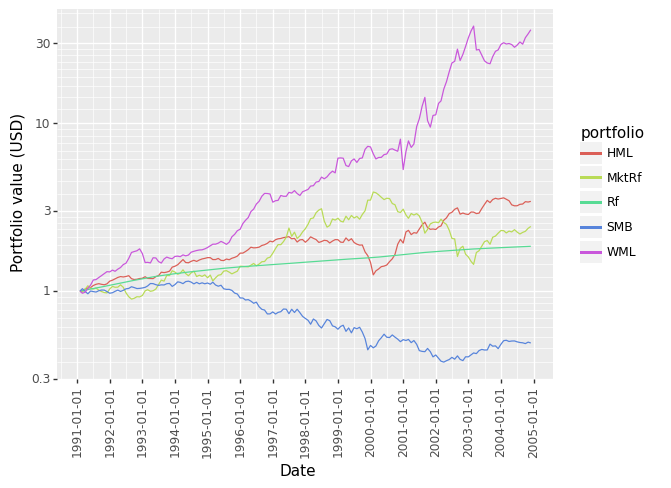

<ggplot: (8768000323006)>


/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


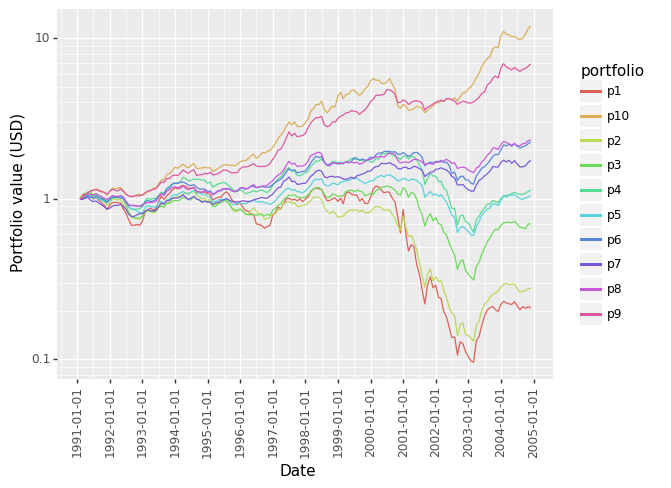

<ggplot: (-9223363268853996663)>


In [ ]:
plotdata = portfolios.melt(id_vars = ['mdate'],var_name = "portfolio",  value_name = 'return') 
plotdata = plotdata.merge(ff[['Rf','mdate']],on = 'mdate')
plotdata['mdate'] = plotdata['mdate'].apply(str)

ports = ['WML','MktRf','HML','SMB']
def conditions(plotdata):
    if plotdata['portfolio'] in ports:
      return 1+plotdata['return']+plotdata['Rf']
    if plotdata['portfolio'] not in ports:
      return 1+plotdata['return']

plotdata['cumret'] = plotdata.apply(conditions, axis=1)

initial_inv = plotdata.portfolio.unique()
initial_inv = pd.DataFrame (initial_inv, columns = ['portfolio'])
initial_inv['mdate'], initial_inv['return'], initial_inv['Rf'], initial_inv['cumret'] = ['199102', 'NA', 'NA', 1]

plotdata = pd.concat([initial_inv, plotdata])
plotdata['cumret'] = plotdata.groupby(['portfolio']).cumprod()

plotdata['date'] = plotdata['mdate'].str[0:4].astype(str)+'-'+plotdata['mdate'].str[-2:].astype(str)+'-01'
plotdata['date'] = pd.to_datetime(plotdata['date'])

ports = ['WML','MktRf','HML','SMB','Rf']

plotdata1 = plotdata[plotdata['portfolio'].isin(ports)]
plotdata2 = plotdata[~plotdata['portfolio'].isin(ports)]

from plotnine import *

print(
    ggplot(plotdata1)
    + aes(x = 'date', y = 'cumret', color = 'portfolio')
    + geom_line()
    + xlab('Date')
    + ylab('Portfolio value (USD)')
    + scale_y_log10()
    + scale_x_date(breaks = ('1 year'))
    + theme(axis_text_x = element_text(rotation = 90))
) 

print(
    ggplot(plotdata2)
    + aes(x = 'date', y = 'cumret', color = 'portfolio')
    + geom_line()
    + xlab('Date')
    + ylab('Portfolio value (USD)')
    + scale_y_log10()
    + scale_x_date(breaks = ('1 year'))
    + theme(axis_text_x = element_text(rotation = 90))
) 